Updates: Pyspark is now installed on my local computer. It turned out to be difficult to load the data from my S3 bucket because dataframes in Pyspark appear to load lazily (if I create a temporary directory to store the files "downloaded" from the S3 bucket, then try to access the dataframe outside of the "with" loop in which the temporary directory exists, it throws a "File Not Found" error.)

So for now, I'm creating a proof-of-concept model with the 1 million record sample I generated using Pandas earlier which I saved to a file in the data folder.

Import Pyspark, start a Spark Session, load the transactions data.

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.appName('H&M Recommendation System').getOrCreate()

23/03/29 19:49:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
%timeit
transactions = spark.read.csv('data/transactions_sample.csv', header=True)

In [4]:
transactions.show(5)

+--------+----------+--------------------+----------+--------------------+----------------+
|     _c0|     t_dat|         customer_id|article_id|               price|sales_channel_id|
+--------+----------+--------------------+----------+--------------------+----------------+
| 6819188|2019-02-28|cf4254f236a7d3f4d...| 639192002| 0.06777966101694917|               1|
| 1937255|2018-10-30|9da5d0fc26ed57853...| 652361003|0.008457627118644067|               2|
|30574525|2020-08-21|52d409edafe2ab3c9...| 877273001| 0.03388135593220338|               1|
| 6990198|2019-03-05|7022f60068ed9d8cb...| 714543001| 0.01254237288135593|               1|
|18501631|2019-11-01|4d4f9a5031d13fdd4...| 765853019| 0.06777966101694917|               2|
+--------+----------+--------------------+----------+--------------------+----------------+
only showing top 5 rows



23/03/29 19:50:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , t_dat, customer_id, article_id, price, sales_channel_id
 Schema: _c0, t_dat, customer_id, article_id, price, sales_channel_id
Expected: _c0 but found: 
CSV file: file:///Users/user/Documents/Flatiron/phase_4/notes/rec_system__h-m/data/transactions_sample.csv


All datatypes are **string**.

| Least Recent Transaction | Most Recent Transaction |
| --- | --- |
| 9/20/2018 | 9/22/2020 |


Filter for the most recent transactions, and determine customer-article purchase counts ("historical_ratings".)

In [5]:
# if you want the most recent year of transactions
recent_transactions = transactions.filter(transactions.t_dat > '2019-9-19')

In [14]:
purchase_counts = recent_transactions.groupBy('customer_id').count()
purchase_counts.agg(F.avg('count')).collect()

[Row(avg(count)=1.4835677120257107)]

In [15]:
purchase_counts.agg(F.stddev('count')).collect()

[Row(stddev_samp(count)=0.9896841504041872)]

On average, each customer in our sample made 1.5 purchases. (Standard deviation of nearly 1.)

In [6]:
historical_ratings = recent_transactions.groupBy(['customer_id', 'article_id']).count()

In [7]:
historical_ratings.show(2)

+--------------------+----------+-----+
|         customer_id|article_id|count|
+--------------------+----------+-----+
|adde61206265d6e1a...| 859400006|    1|
|577a62fedef3ba595...| 828268001|    1|
+--------------------+----------+-----+
only showing top 2 rows



In [18]:
historical_ratings.agg({'count': 'max'}).collect()[0]

Row(max(count)=5)

The most number of times a customer has purchased an article in this dataset is 5.

Train-test-split.

Perform a stratified train-test-split (try to keep 80% of each article_id in the training set.)

In [8]:
fractions = historical_ratings.select('article_id').distinct()\
.withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()

train = historical_ratings.sampleBy(col='article_id',
                                    fractions=fractions,
                                    seed=312)

test = historical_ratings.subtract(train)

In [9]:
train.show(3)

+--------------------+----------+-----+
|         customer_id|article_id|count|
+--------------------+----------+-----+
|adde61206265d6e1a...| 859400006|    1|
|577a62fedef3ba595...| 828268001|    1|
|4f0b41a56d8fc0cc8...| 877961021|    1|
+--------------------+----------+-----+
only showing top 3 rows



Transform features / clean data.

Change all relevant columns to integer type before fitting the model.

In [10]:
train = train.withColumn('article_id', train.article_id.cast('int'))

In [11]:
from pyspark.ml.feature import StringIndexer

si = StringIndexer(inputCol='customer_id',
                   outputCol='customer_index',
                   handleInvalid='keep')

new_train = si.fit(train).transform(train)

In [12]:
new_train = new_train.withColumn('customer_index', new_train.customer_index.cast('int'))

In [13]:
new_train = new_train.withColumn('count', new_train['count'].cast('int'))

In [14]:
new_train.show(2)

23/03/29 19:51:07 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


+--------------------+----------+-----+--------------+
|         customer_id|article_id|count|customer_index|
+--------------------+----------+-----+--------------+
|adde61206265d6e1a...| 859400006|    1|         39570|
|577a62fedef3ba595...| 828268001|    1|          3396|
+--------------------+----------+-----+--------------+
only showing top 2 rows



In [66]:
from pyspark.ml.recommendation import ALS

%timeit

als = ALS(rank=10,
          userCol='customer_index',
          itemCol='article_id',
          ratingCol='count',
          implicitPrefs=True,
          nonnegative=True,
          coldStartStrategy='drop',
          seed=312
         )

model = als.fit(new_train)

print(model)

23/03/29 20:17:51 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:17:52 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:18:14 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:18:32 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:18:34 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:18:49 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:18:51 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:18:53 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:18:54 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:18:55 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:18:56 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:18:58 WARN DAGScheduler: Broadc

ALSModel: uid=ALS_c14c9207315a, rank=10


---
Here are my efforts to use the mllib version of ALS rather than the ml version, so that I can calculate MAP@3 efficiently.

In [15]:
train_tuples = new_train.withColumnRenamed('count', 'rating').drop('customer_id')

In [16]:
train_tuples.show(2)

23/03/29 19:51:17 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


+----------+------+--------------+
|article_id|rating|customer_index|
+----------+------+--------------+
| 859400006|     1|         39570|
| 828268001|     1|          3396|
+----------+------+--------------+
only showing top 2 rows



In [50]:
from pyspark.mllib.recommendation import ALS as ALS2

model2 = ALS2.trainImplicit(train_ratings.rdd, 10, nonnegative=True)

23/03/29 19:17:19 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 19:17:20 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 19:17:21 ERROR Executor: Exception in task 0.0 in stage 68.0 (TID 1195)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark

Py4JJavaError: An error occurred while calling o429.trainImplicitALSModel.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 68.0 failed 1 times, most recent failure: Lost task 0.0 in stage 68.0 (TID 1195, rebeccas-mbp.lan, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/mllib/recommendation.py", line 234, in <lambda>
    ratings = ratings.map(lambda x: Rating(*x))
TypeError: __new__() missing 2 required positional arguments: 'product' and 'rating'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$SliceIterator.hasNext(Iterator.scala:266)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at scala.collection.AbstractIterator.to(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1423)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2133)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.rdd.RDD.$anonfun$take$1(RDD.scala:1423)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1396)
	at org.apache.spark.rdd.RDD.$anonfun$isEmpty$1(RDD.scala:1531)
	at scala.runtime.java8.JFunction0$mcZ$sp.apply(JFunction0$mcZ$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.isEmpty(RDD.scala:1531)
	at org.apache.spark.mllib.recommendation.ALS.run(ALS.scala:241)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainImplicitALSModel(PythonMLLibAPI.scala:514)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 271, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "/Users/user/opt/anaconda3/envs/spark-env/lib/python3.8/site-packages/pyspark/mllib/recommendation.py", line 234, in <lambda>
    ratings = ratings.map(lambda x: Rating(*x))
TypeError: __new__() missing 2 required positional arguments: 'product' and 'rating'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:503)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:638)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$SliceIterator.hasNext(Iterator.scala:266)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at scala.collection.AbstractIterator.to(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1423)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2133)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [41]:
ratings=[Rating(x.asDict()['customer_index'],
                x.asDict()['article_id'],
                x.asDict()['rating']) for x in train_tuples.sample(
    fraction=0.1, seed=312).collect()]

23/03/29 20:05:47 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


In [49]:
ratings_rdd = spark.sparkContext.parallelize(ratings)

In [50]:
from pyspark.mllib.recommendation import ALS as ALS2

model2 = ALS2.trainImplicit(ratings_rdd, 10, nonnegative=True)

23/03/29 20:07:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/29 20:07:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


What we need is a list of the top 3 recommended items for each user, zipped with a "ground truth" from the test set.

In [99]:
new_test.show(2)

23/03/30 10:38:29 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


+--------------------+----------+-----+--------------+
|         customer_id|article_id|count|customer_index|
+--------------------+----------+-----+--------------+
|beb07a60fa9baaa9f...| 859092001|    1|        197933|
|f06e69b81c840b5c0...| 727948001|    1|        197933|
+--------------------+----------+-----+--------------+
only showing top 2 rows



In [112]:
new_test.filter(new_test.customer_index == 5).select('article_id')

AttributeError: 'RDD' object has no attribute 'asDict'

In [110]:
new_test.filter(new_test.customer_index == 5).select('article_id').collect()

23/03/30 11:02:48 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


[Row(article_id=621381001),
 Row(article_id=719629024),
 Row(article_id=864309001),
 Row(article_id=492897001),
 Row(article_id=621381012)]

In [123]:
recommendations.filter(recommendations._1 == 1).select('_2').collect()[0]

IndexError: list index out of range

In [129]:
ranking_tuples = []

for customer_index in [x['_1'] for x in recommendations.select('_1').distinct().collect()]:
    rows1 = recommendations.filter(recommendations._1==customer_index).select('_2').collect()[0]['_2']
    rankings = [row['product'] for row in rows1]
    
    rows2 = new_test.filter(new_test.customer_index == customer_index).select('article_id').collect()
    ground_truth = [x['article_id'] for x in rows2]
    
    ranking_tuples.append((rankings, ground_truth))

23/03/30 11:23:54 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:24:46 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:25:33 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:26:17 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:27:08 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:27:53 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:28:38 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:29:22 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:30:07 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:30:51 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:31:34 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 11:32:17 WARN DAGScheduler: Broadc

23/03/30 12:38:34 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:39:23 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:40:15 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:41:02 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:41:51 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:42:34 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:43:25 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:44:13 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:44:58 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:45:45 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:46:33 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 12:47:18 WARN DAGScheduler: Broadc

23/03/30 14:10:06 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:11:00 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:11:49 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:12:37 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:13:22 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:15:06 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:16:00 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:16:53 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:17:42 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:18:30 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:19:19 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/30 14:20:07 WARN DAGScheduler: Broadc

23/03/31 11:02:58 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:03:48 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:04:39 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:05:30 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:06:19 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:07:09 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:08:00 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:08:48 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:09:41 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:10:28 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:11:14 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 11:12:04 WARN DAGScheduler: Broadc

23/03/31 13:17:57 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:18:49 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:19:36 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:20:31 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:21:20 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:22:11 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:23:01 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:23:55 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:24:47 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:25:37 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:26:24 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/31 13:27:12 WARN DAGScheduler: Broadc

KeyboardInterrupt: 

In [ ]:
ranking_tuples.show(2)

In [128]:
recommendations = model2.recommendProductsForUsers(3).toDF()

In [118]:
[row['product'] for row in recommendations.filter(recommendations._1==5).select('_2').collect()[0]['_2']]

[751471001, 741356002, 372860001]

In [100]:
new_test.withColumn('recommended', model2.recommendProducts('customer_index', 3))

Py4JError: An error occurred while calling o442.recommendProducts. Trace:
py4j.Py4JException: Method recommendProducts([class java.lang.String, class java.lang.Integer]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)



In [ ]:
model2.recommendProducts(user, 3)

In [101]:
model2

In [56]:
testData = ratings_rdd.map(lambda p: (p.user, p.product))
predictions = model2.predictAll(testData).map(lambda r: ((r.user, r.product), r.rating))

ratingsTuple = ratings_rdd.map(lambda r: ((r.user, r.product), r.rating))
scoreAndLabels = predictions.join(ratingsTuple).map(lambda tup: tup[1])

[(0.000714322093696623, 1.0), (3.472187358199223e-11, 1.0)]

In [96]:
scoreAndLabels.take(5)

[(0.000714322093696623, 1.0),
 (3.472187358199223e-11, 1.0),
 (5.869481761830604e-07, 1.0),
 (0.01919505331824229, 1.0),
 (1.0814860265047868e-06, 1.0)]

In [97]:
from pyspark.mllib.evaluation import RankingMetrics

baseline_model_metrics = RankingMetrics(scoreAndLabels)

In [98]:
baseline_model_metrics.meanAveragePrecisionAt(3)

23/03/30 10:35:48 ERROR Executor: Exception in task 3.0 in stage 1363.0 (TID 8153)
java.lang.ClassCastException: class java.lang.Double cannot be cast to class scala.collection.Seq (java.lang.Double is in module java.base of loader 'bootstrap'; scala.collection.Seq is in unnamed module of loader 'app')
	at org.apache.spark.sql.Row.getSeq(Row.scala:317)
	at org.apache.spark.sql.Row.getSeq$(Row.scala:317)
	at org.apache.spark.sql.catalyst.expressions.GenericRow.getSeq(rows.scala:166)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.$anonfun$newRankingMetrics$1(PythonMLLibAPI.scala:1065)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:459)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:459)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at org.apache.spark.util.StatCounter.merge(StatCounter.scala:55)
	at org.apache.spark.util.

Py4JJavaError: An error occurred while calling o1051.meanAveragePrecisionAt.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 1363.0 failed 1 times, most recent failure: Lost task 2.0 in stage 1363.0 (TID 8152, rebeccas-mbp.lan, executor driver): java.lang.ClassCastException: class java.lang.Double cannot be cast to class scala.collection.Seq (java.lang.Double is in module java.base of loader 'bootstrap'; scala.collection.Seq is in unnamed module of loader 'app')
	at org.apache.spark.sql.Row.getSeq(Row.scala:317)
	at org.apache.spark.sql.Row.getSeq$(Row.scala:317)
	at org.apache.spark.sql.catalyst.expressions.GenericRow.getSeq(rows.scala:166)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.$anonfun$newRankingMetrics$1(PythonMLLibAPI.scala:1065)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:459)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:459)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at org.apache.spark.util.StatCounter.merge(StatCounter.scala:55)
	at org.apache.spark.util.StatCounter.<init>(StatCounter.scala:37)
	at org.apache.spark.util.StatCounter$.apply(StatCounter.scala:158)
	at org.apache.spark.rdd.DoubleRDDFunctions.$anonfun$stats$2(DoubleRDDFunctions.scala:43)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:837)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:837)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2188)
	at org.apache.spark.rdd.RDD.$anonfun$reduce$1(RDD.scala:1094)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1076)
	at org.apache.spark.rdd.DoubleRDDFunctions.$anonfun$stats$1(DoubleRDDFunctions.scala:43)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.DoubleRDDFunctions.stats(DoubleRDDFunctions.scala:43)
	at org.apache.spark.rdd.DoubleRDDFunctions.$anonfun$mean$1(DoubleRDDFunctions.scala:48)
	at scala.runtime.java8.JFunction0$mcD$sp.apply(JFunction0$mcD$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.DoubleRDDFunctions.mean(DoubleRDDFunctions.scala:48)
	at org.apache.spark.mllib.evaluation.RankingMetrics.meanAveragePrecisionAt(RankingMetrics.scala:90)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.lang.ClassCastException: class java.lang.Double cannot be cast to class scala.collection.Seq (java.lang.Double is in module java.base of loader 'bootstrap'; scala.collection.Seq is in unnamed module of loader 'app')
	at org.apache.spark.sql.Row.getSeq(Row.scala:317)
	at org.apache.spark.sql.Row.getSeq$(Row.scala:317)
	at org.apache.spark.sql.catalyst.expressions.GenericRow.getSeq(rows.scala:166)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.$anonfun$newRankingMetrics$1(PythonMLLibAPI.scala:1065)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:459)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:459)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at org.apache.spark.util.StatCounter.merge(StatCounter.scala:55)
	at org.apache.spark.util.StatCounter.<init>(StatCounter.scala:37)
	at org.apache.spark.util.StatCounter$.apply(StatCounter.scala:158)
	at org.apache.spark.rdd.DoubleRDDFunctions.$anonfun$stats$2(DoubleRDDFunctions.scala:43)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:837)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:837)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


---
Back to the ml.recommendation ALS model.

In [68]:
train_predictions = model.transform(new_train)
train_predictions.show(5)

23/03/29 20:20:46 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:20:46 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:20:48 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 20:21:15 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 20:21:52 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


+--------------------+----------+-----+--------------+-------------+
|         customer_id|article_id|count|customer_index|   prediction|
+--------------------+----------+-----+--------------+-------------+
|bee1609ea3ae56cf2...| 126589006|    1|        160676|          0.0|
|c8d946756335665f1...| 201219001|    1|          4929| 3.4413097E-7|
|7960918e6f907cca6...| 201219001|    1|        120418| 1.5044737E-8|
|d827509e61518f012...| 201219001|    1|         14210| 2.4846895E-7|
|a6a5de89a30288d32...| 201219001|    1|         38539|1.47105625E-8|
+--------------------+----------+-----+--------------+-------------+
only showing top 5 rows



In [72]:
top_3_recs = model.recommendForAllUsers(3)

In [70]:
test = test.withColumn('article_id', test.article_id.cast('int'))

new_test = si.fit(train).transform(test)

new_test = new_test.withColumn('customer_index', new_test.customer_index.cast('int'))

new_test = new_test.withColumn('count', new_test['count'].cast('int'))

In [71]:
new_test.show(1)

23/03/29 20:25:19 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


+--------------------+----------+-----+--------------+
|         customer_id|article_id|count|customer_index|
+--------------------+----------+-----+--------------+
|beb07a60fa9baaa9f...| 859092001|    1|        197933|
+--------------------+----------+-----+--------------+
only showing top 1 row



In [74]:
num_customers = top_3_recs.select('customer_index').distinct().count()
num_customers

23/03/29 20:27:46 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 20:29:00 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


196724

In [120]:
# if you remove the filter, you can get metrics for ALL recommendations =)

recommended = [ x['article_id'] for x in top_5_recommendations.filter(
    top_5_recommendations.customer_index == 1
).collect()[0]['recommendations'] ]

23/03/29 15:41:28 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 15:42:52 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


In [119]:
ground_truth = [x['article_id'] for x in new_test.filter(new_test.customer_index==1).collect()]

23/03/29 15:40:55 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


In [121]:
print('Recommended:')
print(recommended)
print('\nGround Truth:')
print(ground_truth)

Recommended:
[872105001, 926921002, 689898002, 899364002, 870351001]

Ground Truth:
[838787005, 859176002]


In [124]:
results = spark.sparkContext.parallelize([(recommended, ground_truth)])

In [125]:
from pyspark.mllib.evaluation import RankingMetrics

baseline_model_metrics = RankingMetrics(results)

In [128]:
baseline_model_metrics.precisionAt(3) # all are zero because I didn't get any correct xD

0.0

In [131]:
new_train.select('customer_index').count()

274708

In [139]:
[x['article_id'] for x in top_5_recommendations.filter("customer_index = 5").select('recommendations').collect()[0]['recommendations']]

23/03/29 16:29:29 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 16:30:44 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


[877607001, 852940001, 848175001, 872105001, 868060005]

In [78]:
[x['article_id'] for x in top_3_recs.filter('customer_index = 5')][0]

Column<b'customer_index[article_id]'>

In [80]:
top_3_recs.filter('customer_index = 5').select('recommendations').collect()

23/03/29 20:35:26 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 20:36:36 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


[Row(recommendations=[Row(article_id=372860001, rating=0.015275676734745502), Row(article_id=791587001, rating=0.012520085088908672), Row(article_id=448509014, rating=0.010398919694125652)])]

In [86]:
[x[0] for x in top_3_recs.filter('customer_index = 5').select('recommendations').collect()]

23/03/29 21:12:56 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 21:14:06 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


[[Row(article_id=372860001, rating=0.015275676734745502),
  Row(article_id=791587001, rating=0.012520085088908672),
  Row(article_id=448509014, rating=0.010398919694125652)]]

In [88]:
[x[0][i]['article_id'] for i, x in enumerate(top_3_recs.filter('customer_index=5').select('recommendations').collect())]

23/03/29 21:20:15 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 21:21:25 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


[372860001]

In [89]:
top_3_recs.filter('customer_index=5').select('recommendations').collect()

23/03/30 10:13:27 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/30 10:14:39 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


[Row(recommendations=[Row(article_id=372860001, rating=0.015275676734745502), Row(article_id=791587001, rating=0.012520085088908672), Row(article_id=448509014, rating=0.010398919694125652)])]

In [90]:
top_3_recs.filter('customer_index=5').select('recommendations').collect()[0]

23/03/30 10:15:09 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/30 10:16:20 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


Row(recommendations=[Row(article_id=372860001, rating=0.015275676734745502), Row(article_id=791587001, rating=0.012520085088908672), Row(article_id=448509014, rating=0.010398919694125652)])

In [91]:
top_3_recs.filter('customer_index=5').select('recommendations').collect()[0]['recommendations']

23/03/30 10:25:29 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/30 10:26:40 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


[Row(article_id=372860001, rating=0.015275676734745502),
 Row(article_id=791587001, rating=0.012520085088908672),
 Row(article_id=448509014, rating=0.010398919694125652)]

In [82]:
recommended = []
ground_truth = []

for customer_index in range(num_customers - 2): # don't include "catch-all" customer index
    customer_recs = top_3_recs.filter(f'customer_index = {customer_index}').select('recommendations').collect()[0]
    recommended.append([x['article_id'] for x in customer_recs])
    recommended.append([
        x['article_id'] for x in top_3_recs.filter(f"customer_index = {customer_index}"
        ).select('recommendations').collect()[0]\
                   ['recommendations']
                  ])
    ground_truth.append([
        x['article_id'] for x in new_test.filter(
            new_test.customer_index==customer_index
        ).collect()
    ])

results = spark.sparkContext.parallelize([(recommended, ground_truth)])
baseline_model_metrics = RankingMetrics(results)
print(baseline_model_metrics.meanAveragePrecisionAt(3))

23/03/29 20:39:58 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 20:41:07 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


TypeError: list indices must be integers or slices, not str

In [104]:
model.recommendForUserSubset(test_customers, 2).show()

23/03/29 14:55:16 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 14:55:39 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
23/03/29 14:55:55 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 14:56:13 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 14:56:13 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 14:56:14 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 14:56:16 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
23/03/29 14:56:24 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


+--------------+--------------------+
|customer_index|     recommendations|
+--------------+--------------------+
|        121486|[[879176002, 0.91...|
|          4066|[[848175001, 1.69...|
|         14094|[[734895002, 1.18...|
+--------------+--------------------+



In [67]:
model.itemFactors.show(3)

23/03/29 14:19:41 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


+---------+--------------------+
|       id|            features|
+---------+--------------------+
|126589010|[0.3124433, 0.183...|
|153115020|[-0.2535459, 0.15...|
|153115040|[-0.25943932, 0.4...|
+---------+--------------------+
only showing top 3 rows



---

In [19]:
fractions = historical_ratings.select('article_id').distinct()\
.withColumn("fraction", F.lit(0.7)).rdd.collectAsMap()

In [61]:
article_reviews = historical_ratings.groupBy('article_id').count()
print(f'Mean number of "reviews": {article_reviews.agg(F.mean("count")).collect()}')
print(f'Standard deviation: {article_reviews.agg(F.stddev("count")).collect()}')
print(f'Articles with fewer than 10 "reviews": {article_reviews.filter("count < 10").count()}')

Mean number of "reviews": [Row(avg(count)=10.43766150852765)]


Standard deviation: [Row(stddev_samp(count)=19.892564890781237)]


Articles with fewer than 10 "reviews": 23717


In [62]:
historical_ratings.select('article_id').distinct().count()

32893

In [63]:
32893 - 23717

9176

Filter for articles which have been purchased by more than 10 distinct customers.

ONLY include these interactions in our train and test sets!

In [67]:
article_reviews.filter('count < 10').select('article_id').show(2)

+----------+
|article_id|
+----------+
| 644797009|
| 757813009|
+----------+
only showing top 2 rows



In [69]:
fake_df.show(2)

+-----------+----------+----------+
|customer_id|article_id|sum(count)|
+-----------+----------+----------+
|       3240|         9|         2|
|       2314|        18|         4|
+-----------+----------+----------+
only showing top 2 rows



In [73]:
fake_df.filter("article_id in (2, 5, 9)").show()

+-----------+----------+----------+
|customer_id|article_id|sum(count)|
+-----------+----------+----------+
|       3240|         9|         2|
|       2314|         9|         2|
|       1010|         5|         5|
|       2314|         2|         1|
|       1010|         9|         5|
+-----------+----------+----------+



In [80]:
most_reviewed_articles = article_reviews.filter('count > 10').select('article_id').collect()

In [82]:
most_reviewed_articles = tuple([x[0] for x in most_reviewed_articles])

In [86]:
final_historical_ratings=historical_ratings.filter(f"article_id in {most_reviewed_articles}")

In [87]:
fractions = final_historical_ratings.select('article_id').distinct()\
.withColumn("fraction", F.lit(0.7)).rdd.collectAsMap()

train = final_historical_ratings.sampleBy(col='article_id',
                                          fractions=fractions,
                                          seed=312)

test = final_historical_ratings.subtract(train)

In [88]:
train.select('article_id').distinct().count()

8464

In [89]:
final_historical_ratings.select('article_id').distinct().count()

8464

In [90]:
test.select('article_id').distinct().count()

8425

In [25]:
import numpy as np
fake_customers = []
for i in range(60):
    fake_customers.append((1010, np.random.randint(1, 20), np.random.randint(1, 3)))
for i in range(20):
    fake_customers.append((2314, np.random.randint(1, 20), np.random.randint(1, 3)))
for i in range(10):
    fake_customers.append((3240, np.random.randint(1, 20), np.random.randint(1, 3)))

fake_df = spark.createDataFrame(fake_customers, schema=('customer_id', 'article_id', 'count'))

fake_df.show(5)

+-----------+----------+-----+
|customer_id|article_id|count|
+-----------+----------+-----+
|       1010|         4|    1|
|       1010|         5|    2|
|       1010|        19|    2|
|       1010|         9|    2|
|       1010|         4|    1|
+-----------+----------+-----+
only showing top 5 rows



In [44]:
fake_df = fake_df.groupBy(['customer_id', 'article_id']).agg(F.sum('count'))

In [45]:
fake_df.groupBy('customer_id').count().show()

+-----------+-----+
|customer_id|count|
+-----------+-----+
|       1010|   18|
|       3240|    7|
|       2314|   13|
+-----------+-----+



In [46]:
fake1 = fake_df.sampleBy('customer_id', {1010: 0.5, 2314: 0.5, 3240: 0.5}, seed=2)
fake1.groupBy('customer_id').count().show()

+-----------+-----+
|customer_id|count|
+-----------+-----+
|       1010|   10|
|       3240|    5|
|       2314|    6|
+-----------+-----+



In [47]:
fake1_counterpart = fake_df.subtract(fake1)
fake1_counterpart.groupBy('customer_id').count().show()

+-----------+-----+
|customer_id|count|
+-----------+-----+
|       1010|    8|
|       3240|    2|
|       2314|    7|
+-----------+-----+



In [112]:
train.filter(train.article_id.isNull()).show()

+-----------+----------+-----+
|customer_id|article_id|count|
+-----------+----------+-----+
+-----------+----------+-----+



In [113]:
train.filter(train.customer_id.isNull()).show()

+-----------+----------+-----+
|customer_id|article_id|count|
+-----------+----------+-----+
+-----------+----------+-----+



In [114]:
train.filter(train['count'].isNull()).show()

+-----------+----------+-----+
|customer_id|article_id|count|
+-----------+----------+-----+
+-----------+----------+-----+



In [116]:
si_customer_model = si_customer.fit(train)

In [119]:
si_customer_model.setHandleInvalid('keep')

StringIndexerModel: uid=StringIndexer_0815572446b0, handleInvalid=error

In [120]:
customer_indexed = si_customer_model.transform(train)

In [122]:
si_article_model = si_article.fit(customer_indexed)

In [123]:
si_article_model.setHandleInvalid('keep')

StringIndexerModel: uid=StringIndexer_43115dcdabd8, handleInvalid=error

In [124]:
customer_and_article_indexed = si_article_model.transform(customer_indexed)

In [125]:
customer_and_article_indexed.show(2)

23/03/29 13:24:02 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


+--------------------+----------+-----+--------------+-------------+
|         customer_id|article_id|count|customer_index|article_index|
+--------------------+----------+-----+--------------+-------------+
|adde61206265d6e1a...| 859400006|    1|      108321.0|       3645.0|
|577a62fedef3ba595...| 828268001|    1|       14123.0|       2523.0|
+--------------------+----------+-----+--------------+-------------+
only showing top 2 rows



---
work from before:

In [102]:
from pyspark.ml.feature import StringIndexer

si_customer = StringIndexer(inputCol='customer_id', outputCol='customer_index')
customer_indexed = si_customer.fit(train).transform(train)

customer_indexed.show(3)

23/03/29 12:59:37 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


+--------------------+----------+-----+--------------+
|         customer_id|article_id|count|customer_index|
+--------------------+----------+-----+--------------+
|adde61206265d6e1a...| 859400006|    1|      108321.0|
|577a62fedef3ba595...| 828268001|    1|       14123.0|
|ca07736ee34cafb16...| 682511001|    1|       23803.0|
+--------------------+----------+-----+--------------+
only showing top 3 rows



In [103]:
si_article = StringIndexer(inputCol='article_id', outputCol='article_index')
customer_and_article_indexed = si_article.fit(customer_indexed).transform(customer_indexed)
customer_and_article_indexed.show(3)

23/03/29 13:00:44 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


+--------------------+----------+-----+--------------+-------------+
|         customer_id|article_id|count|customer_index|article_index|
+--------------------+----------+-----+--------------+-------------+
|adde61206265d6e1a...| 859400006|    1|      108321.0|       3645.0|
|577a62fedef3ba595...| 828268001|    1|       14123.0|       2523.0|
|ca07736ee34cafb16...| 682511001|    1|       23803.0|       7486.0|
+--------------------+----------+-----+--------------+-------------+
only showing top 3 rows



---
end of work from before^

Quickly check for null values:

In [126]:
customer_and_article_indexed.filter(customer_and_article_indexed.article_index.isNull()).show()

+-----------+----------+-----+--------------+-------------+
|customer_id|article_id|count|customer_index|article_index|
+-----------+----------+-----+--------------+-------------+
+-----------+----------+-----+--------------+-------------+



In [127]:
customer_and_article_indexed.filter(customer_and_article_indexed.customer_index.isNull()).show()

+-----------+----------+-----+--------------+-------------+
|customer_id|article_id|count|customer_index|article_index|
+-----------+----------+-----+--------------+-------------+
+-----------+----------+-----+--------------+-------------+



In [128]:
customer_and_article_indexed.filter(customer_and_article_indexed['count'].isNull()).show()

+-----------+----------+-----+--------------+-------------+
|customer_id|article_id|count|customer_index|article_index|
+-----------+----------+-----+--------------+-------------+
+-----------+----------+-----+--------------+-------------+



In [129]:
customer_and_article_indexed.dtypes

[('customer_id', 'string'),
 ('article_id', 'string'),
 ('count', 'bigint'),
 ('customer_index', 'double'),
 ('article_index', 'double')]

In [133]:
df2 = train.select([F.count(F.when(F.col(c).contains('None') | \
                            F.col(c).contains('NULL') | \
                            (F.col(c) == '' ) | \
                            F.col(c).isNull() | \
                            F.isnan(c), c 
                           )).alias(c)
                    for c in train.columns])

df2.show()

+-----------+----------+-----+
|customer_id|article_id|count|
+-----------+----------+-----+
|          0|         0|    0|
+-----------+----------+-----+



In [130]:
from pyspark.ml.recommendation import ALS

als = ALS(rank=10,
          userCol='customer_index',
          itemCol='article_index',
          ratingCol='count',
          coldStartStrategy='drop',
          seed=312
         )

model = als.fit(customer_and_article_indexed)

print(model)

23/03/29 13:24:56 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
23/03/29 13:24:57 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
23/03/29 13:25:15 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
23/03/29 13:25:30 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
23/03/29 13:25:33 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
23/03/29 13:25:45 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
23/03/29 13:25:47 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
23/03/29 13:25:47 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/29 13:25:47 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/03/29 13:25:48 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
23/03/29 13:25:49 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.N

ALSModel: uid=ALS_030f5a368ff2, rank=10


In [92]:
from pyspark.ml.recommendation import ALS

als = ALS(rank=10,
           userCol='customer_id_indexed',
           itemCol='article_id_indexed',
           ratingCol='count',
           coldStartStrategy='drop', 
           seed=312)

model = als.fit(all_transformed)

print(model)

23/03/29 12:50:14 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
23/03/29 12:50:16 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
23/03/29 12:50:16 ERROR Executor: Exception in task 5.0 in stage 291.0 (TID 11670)
org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$4037/0x00000008014b4040: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.agg_doAggregateWithKeysOutput_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)

23/03/29 12:50:17 WARN TaskSetManager: Lost task 8.0 in stage 291.0 (TID 11673, rebeccas-mbp.lan, executor driver): TaskKilled (Stage cancelled)
23/03/29 12:50:17 WARN TaskSetManager: Lost task 9.0 in stage 291.0 (TID 11674, rebeccas-mbp.lan, executor driver): TaskKilled (Stage cancelled)


Py4JJavaError: An error occurred while calling o536.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 291.0 failed 1 times, most recent failure: Lost task 6.0 in stage 291.0 (TID 11671, rebeccas-mbp.lan, executor driver): org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$4037/0x00000008014b4040: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.agg_doAggregateWithKeysOutput_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$ConcatIterator.hasNext(Iterator.scala:222)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Unseen label: d8ca464a9faf1b8cf3c539b00cba6a99fd2f5bc7307aa4ce7ea0fe23a0110210. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:405)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:390)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1227)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:960)
	at org.apache.spark.ml.recommendation.ALS.$anonfun$fit$1(ALS.scala:709)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:691)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:593)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$4037/0x00000008014b4040: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.agg_doAggregateWithKeysOutput_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$ConcatIterator.hasNext(Iterator.scala:222)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Unseen label: d8ca464a9faf1b8cf3c539b00cba6a99fd2f5bc7307aa4ce7ea0fe23a0110210. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:405)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:390)
	... 20 more


In [15]:
type(model)

pyspark.ml.recommendation.ALSModel

In [21]:
model.itemFactors.show(2)

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[0.30789003, -0.2...|
| 10|[-0.25225398, -0....|
+---+--------------------+
only showing top 2 rows



23/03/29 11:09:01 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


In [22]:
test.show(2)

+--------------------+----------+-----+
|         customer_id|article_id|count|
+--------------------+----------+-----+
|003ca8034fe32b9ba...| 836344002|    1|
|006a06ee01161c997...| 827083004|    1|
+--------------------+----------+-----+
only showing top 2 rows



In [23]:
test_transformed = si_model.transform(test)
all_test_transformed = si_model2.transform(test_transformed)

all_test_transformed.show(2)

23/03/29 11:09:18 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
23/03/29 11:09:18 ERROR Executor: Exception in task 0.0 in stage 154.0 (TID 1734)
org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$3528/0x00000008013ff040: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:340)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:872)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:872)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.comp

Py4JJavaError: An error occurred while calling o259.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 154.0 failed 1 times, most recent failure: Lost task 0.0 in stage 154.0 (TID 1734, rebeccas-mbp.lan, executor driver): org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$3528/0x00000008013ff040: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:340)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:872)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:872)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Unseen label: 006a06ee01161c9972f6a05e197b55918cae265343f7d9799eb37f0ce8fb6189. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:405)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:390)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2023)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:1972)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:1971)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1971)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:950)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:950)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2203)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2152)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2141)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:752)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2093)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2133)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:467)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:420)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3625)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2695)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3616)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:763)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3614)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2695)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2902)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:300)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:337)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(StringIndexerModel$$Lambda$3528/0x00000008013ff040: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:340)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:872)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:872)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:444)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:447)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: Unseen label: 006a06ee01161c9972f6a05e197b55918cae265343f7d9799eb37f0ce8fb6189. To handle unseen labels, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:405)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:390)
	... 17 more


In [61]:
model.recommendForUserSubset()

Param(parent='ALS_bc3e57749114', name='predictionCol', doc='prediction column name.')

----

In [ ]:
import boto3
import tempfile
import os

with tempfile.TemporaryDirectory() as tempdir:
    s3 = boto3.client('s3')
    response = s3.list_objects_v2(Bucket='h-and-m')
    s3_objects = [obj['Key'] for obj in response['Contents']]
    
#     local_file_path = os.path.join(tempdir, s3_objects[0])
#     s3.download_file('h-and-m', s3_objects[0], local_file_path)
#     current_transaction = spark.read.csv(local_file_path)
    
    for s3_file in s3_objects:
        local_file_path = os.path.join(tempdir, s3_file)
        s3.download_file('h-and-m', s3_file, local_file_path)
        new_transactions = spark.read.csv(local_file_path)
        if s3_file == 'transactions0.csv':
            transactions = new_transactions
        else:
            transactions = transactions.union(new_transactions)

# H&M Recommendation System

This notebook has turned into an amalgamation of i.) trying to upload the H&M transactions data to an S3 bucket so that I can use PySpark in DataBricks to handle the large volume of data (*top*) and ii.) my original attempt to build a proof of concept recommendation system for H&M using transactions data stored in a numpy array (*bottom*.)

In this section, I connect to my S3 bucket for this project's data: h-and-m.

In [1]:
import boto3

In [4]:
s3 = boto3.client('s3')

In [5]:
response = s3.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  h-and-m


Here, I tried to upload the zipped H&M data in this directory in its entirety to my S3 bucket. The process took hours and then seemed to time out without uploading the file.

In [10]:
filename='data/h-and-m-personalized-fashion-recommendations.zip'

s3.upload_file(
    filename, 'h-and-m', 'h-and-m-data'
)

ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "https://h-and-m.s3.us-east-2.amazonaws.com/h-and-m-data?uploadId=W79VT8TxeH.TkpwnCgagoJysLfuEx2XECddK8U2AqKSERieWxJjeNZFfiGgFjjHjVwiKiMQl6ry3h7f2_8tGJce9P0COCaQzXLT8_glBXNYZDkcSZYZ6FsMw6eOBf.Ps&partNumber=858".

As a work-around, I decided to load the transactions data into a Pandas dataframe (which takes a long-ish time, but still less than a minute) and then split it into packets which can be uploaded separately to the S3 bucket through the AWS console. This is not ideal, but it's better than being stuck for days trying to understand how the AWS connection works, data upload speeds, etc.

I'm going to copy some of the code from below in my original project proof of concept here, so that I can keep all of my work for uploading the data to an S3 bucket in one place.

In [14]:
# imports
from zipfile import ZipFile
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'pandas'

In [ ]:
%%time
# load ALL transactions into a Pandas dataframe
with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('transactions_train.csv') as f:
        transactions = pd.read_csv(f)

Split the data into 64 packets, roughly equally sized though it doesn't need to be exact. Save each one to a .csv file in a folder called "packets" within the data directory.

In [21]:
indices = [int(x) for x in np.linspace(0, transactions.shape[0], 64)]

for i in range(len(indices)-1):
    start = indices[i]
    stop = indices[i+1]
    packet = transactions.loc[start:stop, :].copy()
    with open(f"data/packets/transactions{i}.csv", "x") as f:
        packet.to_csv(f)

IndexError: list index out of range

# H&M Recommendation System

This notebook is my proof-of-concept for a recommendation system for H&M to provide personalized recommendations to users while browsing their website.

Data

[Source](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview)

In [11]:
seed = 39

In [12]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's load the tabular data on transactions first. This will be the bread and butter of our recommendation system (though we need to address the cold start problem and look at ways of improving beyond simple matrix factorization.) The data is large, so out of curiosity, I am going to time the execution of the cell below which reads in the transaction data as a pandas dataframe.

In [13]:
%%time

with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('transactions_train.csv') as f:
        transactions = pd.read_csv(f)

CPU times: user 32 s, sys: 3.67 s, total: 35.6 s
Wall time: 39 s


In [14]:
# how many records and features are in the full transactions file?
print(transactions.shape)

(31788324, 5)


There is no need to use all 31 million + transactions to develop a proof of concept! I am going to take a random sample of 1 million transactions (which is about 3% of the data) to develop a proof of concept model.

In [5]:
transactions_sample = transactions.sample(1000000, random_state=seed).copy()

In [7]:
# save to file, so I don't have to reload entire transactions dataset everytime
with open("data/transactions_sample.csv", "x") as f:
    transactions_sample.to_csv(f)

In [3]:
# test that file is saved
transactions_sample = pd.read_csv('data/transactions_sample.csv', index_col=0)

In [4]:
transactions_sample.head()

,t_dat,customer_id,article_id,price,sales_channel_id
6819188,2019-02-28,cf4254f236a7d3f4d13590ab316524c245113a755786ad...,639192002,0.067780,1
1937255,2018-10-30,9da5d0fc26ed578538293270b501d5d040b85c43b27743...,652361003,0.008458,2
30574525,2020-08-21,52d409edafe2ab3c946d7b6a9bacc1cc6f09fe31a0fa9e...,877273001,0.033881,1
6990198,2019-03-05,7022f60068ed9d8cb9270bdc4cf070d5054b9ba026a450...,714543001,0.012542,1
18501631,2019-11-01,4d4f9a5031d13fdd485d15a0c51b611db30a1a8bd5b45e...,765853019,0.067780,2


Within this sample, we have:

| Number of Unique Customers | Number of Unique Articles |
| --- | --- |
| 486,887 | 71,886 |

In our entire dataset, we have:

| Number of Unique Customers | Number of Unique Articles |
| --- | --- |
| 1,371,980 | 105,542 |

Practically speaking, I don't think it's a problem that we are not representing anywhere close to all customers in the system in our sample.

Having the unique articles represented seems more important to me. Hopefully three quarters of them is enough.

## Visualizations

The code below plots the percentage of transactions accounted for by the first $n$ articles listed by popularity. I plan to use this plot to eyeball a "head" for my items and get a sense of how my recommender may struggle with the long tail problem for this data.

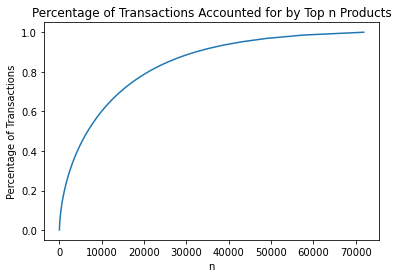

In [5]:
fig, ax = plt.subplots()

plt.plot(range(1, len(transactions_sample.article_id.value_counts()) + 1),
         np.cumsum(transactions_sample.article_id.value_counts(normalize=True)).values)
ax.set(title='Percentage of Transactions Accounted for by Top n Products',
       xlabel = 'n',
       ylabel = 'Percentage of Transactions');

Out of a little over 70,000 unique products in our sample, more than half of transactions involve less than 10,000 of them.

Let's see if we can plot a long tail plot.

In [6]:
# select number of transactions including each article
article_popularity = transactions_sample.article_id.value_counts()

The value counts series above (for the article_id column of transactions_sample) links each article id to the number of times that article was purchased.

| article_id | number of purchases |
| --- | --- |
|  |  |

Below, I reset the index of this series to reference each article by its relative popularity, rather than its unique id.

For example: index 0 refers to the number 1 most popular item, index 1 refers to the second most popular item, etc.

The values in the series still specify how many transactions involved that article. From this series, we can generate our long tail plot.

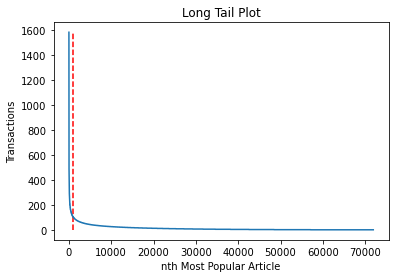

In [7]:
# plot number of transactions versus nth most popular article
fig, ax = plt.subplots()

plt.plot(article_popularity.reset_index().drop(['index'], axis=1))
ax.set(title='Long Tail Plot', xlabel='nth Most Popular Article', ylabel='Transactions')

# highlight the point at which less than 100 transactions include an item
article_no = list(article_popularity.values).index(100)

plt.vlines(x=article_no,
           ymin=0,
           ymax=max(article_popularity.values),
           linestyles='dashed',
           color='r');

Most of our transactions involved articles which were purchased fewer than 100 times. This could be a good thing for training our recommendation system, if most of the items are in the long tail. However, we may want to drop the 1074 most popular items (purchased more than 100 times each) if the system is struggling to provide coverage.

Out of curiosity and practicality, how many items were only purchased once?

---

14,821 items were only purchased once.

1,074 items have been purchased over 100 times.

55,991 items are "in the middle".

This is my first time building a recommendation system, so I want to take a moment to think through how I should structure this project.

- explore metadata on articles & customers
- decide on an evaluation metric
- determine a validation strategy
- decide how to pull the data together: use article_

In [8]:
%%time

with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('articles.csv') as f:
        articles = pd.read_csv(f)

CPU times: user 1.01 s, sys: 41.5 ms, total: 1.05 s
Wall time: 1.05 s


In [33]:
articles.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,image
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,None
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,None


In [34]:
articles.shape

(105542, 26)

In [9]:
%%time

with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('customers.csv') as f:
        customers = pd.read_csv(f)

CPU times: user 4.04 s, sys: 231 ms, total: 4.28 s
Wall time: 4.4 s


In [12]:
customers.head(2)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...


In [45]:
customers.shape

(1371980, 7)

----

I am going to select 800,000 transactions to constitute the training data and 200,000 transactions to make up the hold out test set.

Then, I am going to further subdivide the training data into true training and validation data with a 75% / 25% split.

In [10]:
# get training data (including validation)
train = transactions_sample.sample(800000, random_state=seed).copy()
# which indices are "leftover" after selecting training data?
test_indices = list(set(transactions_sample.index) - set(train.index))
# get test data
test = transactions_sample.loc[ test_indices ].copy()

# get validation data
val = train.sample(200000, random_state=seed).copy()
train_indices = list(set(train.index) - set(val.index))

# reset train to NOT include validation data
train = train.loc[ train_indices ].copy()

In [11]:
print(train.shape)
print(val.shape)
print(test.shape)

(600000, 5)
(200000, 5)
(200000, 5)


## Model 1

Building a recommendation system which uses alternating least squares to obtain a PQ factorization of the utility matrix.

### Build Utility Matrix from Customers & Articles in Training Transaction Data

Recall that the utility matrix refers to the user-item ratings matrix.

In our case, we are using implicit ratings = number of times that a customer has bought an article.

Get the unique customers and articles in the training data.

In [12]:
unique_customers = np.unique(train.customer_id)
unique_articles = np.unique(train.article_id)

Label encode the unique customers and articles so that you can index the utility matrix in base numpy. (Only Pandas lets the index and column names be non-integer or non-consecutive integer.)

In [13]:
from sklearn.preprocessing import LabelEncoder

customer_le = LabelEncoder()
article_le = LabelEncoder()

customer_code = customer_le.fit_transform(unique_customers)
article_code = article_le.fit_transform(unique_articles)

Create a matrix of zeros of the appropriate size for the utility matrix.

In [14]:
utility = np.zeros((len(customer_code), len(article_code)))

Grab transaction information from the training data.

In [15]:
train_transactions = train.loc[:, ['customer_id', 'article_id']].copy()

Label encode the customer and article ids in the training data.

In [16]:
train_transactions['customer_id'] = customer_le.transform(train_transactions['customer_id'])
train_transactions['article_id'] = article_le.transform(train_transactions['article_id'])

Iterate over each row representing a transaction in the training data, and add 1 to the appropriate \[user, item\] entry in the utility matrix.

In [17]:
for i, index in enumerate(train_transactions.index):
    code = train_transactions.loc[index, 'customer_id']
    article = train_transactions.loc[index, 'article_id']
    
    utility[code, article] += 1

*To save space, checking the utility matrix has been deleted.*

### Use Alternating Least Squares to Approximate $PQ^T$ Factorization of Utility Matrix

To get a handle on the process, let's start with $k=5$ latent factors, and build the rank 5 $PQ^{T}$ approximation of the utility / ratings matrix.

The idea behind alternating least squares is to "guess" the values of P and Q, then iteratively update these entries according to least squares.

In [28]:
k = 5

users = np.ones((utility.shape[0], k))
items = np.ones((utility.shape[1], k))

In [ ]:
from sklearn.linear_model import LinearRegression

for row in range(utility.shape[0]):
    lr = LinearRegression(fit_intercept=False)
    # rows of items are "records", target is first row of utility matrix
    lr.fit(items, utility[row,:].reshape(-1, 1))

    users[row, :] = lr.coef_[0]

In [ ]:
users

In [ ]:
for col in range(utility.shape[1]):
    lr = LinearRegression(fit_intercept=False)
    
    lr.fit(users, utility[:, col])
    
    items[:, col] = lr.coef_[0]